<a href="https://colab.research.google.com/github/Adityaphadke270599/AI-Healthcare/blob/main/AI_HealthCare_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandas numpy scikit-learn tensorflow matplotlib seaborn

In [ ]:
from google.colab import files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [ ]:
icustays_path = "/content/ICUSTAYS.csv.gz"  # Update with actual path
icustays = pd.read_csv(icustays_path, compression= 'gzip')

In [ ]:
# Define the file paths
labevents_path = "/content/LABEVENTS.csv.gz"  # Update with actual path
admissions_path = "/content/ADMISSIONS.csv.gz"  # Update with actual path
patients_path = "/content/PATIENTS.csv.gz"  # Update with actual path

# Read the CSV files using the paths
labevents = pd.read_csv(labevents_path, compression='gzip') # Note the compression for .gz
admissions = pd.read_csv(admissions_path, compression='gzip' )
patients = pd.read_csv(patients_path, compression='gzip')


In [ ]:
chartevents_path = "/content/CHARTEVENTS_COMPRESSED.csv"  # Update with actual path
chartevents = pd.read_csv(chartevents_path)

In [ ]:
# Inspect the first few rows of each dataset
print("LABEVENTS Data:")
print(labevents.head())

print("\nADMISSIONS Data:")
print(admissions.head())

print("\nPATIENTS Data:")
print(patients.head())

print("\nICUSTAYS Data:")
print(icustays.head())

print("\nCHARTEVENTS Data:")
print(chartevents.head())


LABEVENTS Data:
   SUBJECT_ID  HADM_ID  ITEMID  VALUENUM            CHARTTIME
0           3      NaN   50820      7.39  2101-10-12 16:07:00
1           3      NaN   50800       NaN  2101-10-12 18:17:00
2           3      NaN   50802     -1.00  2101-10-12 18:17:00
3           3      NaN   50804     22.00  2101-10-12 18:17:00
4           3      NaN   50808      0.93  2101-10-12 18:17:00

ADMISSIONS Data:
   SUBJECT_ID  HADM_ID            ADMITTIME            DISCHTIME  \
0          22   165315  2196-04-09 12:26:00  2196-04-10 15:54:00   
1          23   152223  2153-09-03 07:15:00  2153-09-08 19:10:00   
2          23   124321  2157-10-18 19:34:00  2157-10-25 14:00:00   
3          24   161859  2139-06-06 16:14:00  2139-06-09 12:48:00   
4          25   129635  2160-11-02 02:06:00  2160-11-05 14:55:00   

   HOSPITAL_EXPIRE_FLAG  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

PATIENTS Data:
   SUBJECT_ID

In [ ]:
# Select relevant columns for each dataset
labevents = labevents[['SUBJECT_ID', 'HADM_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME']]
admissions = admissions[['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'HOSPITAL_EXPIRE_FLAG']]
patients = patients[['SUBJECT_ID', 'GENDER', 'DOB']]
icustays = icustays[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'LOS']]
chartevents = chartevents[['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'ITEMID', 'VALUENUM', 'CHARTTIME']]


In [ ]:
# Ventilator-related ITEMIDs
ventilator_itemids = [ 682, 224685, 505, 224696, 683, 224684, 618, 619, 224690, 224695,224700, 224701]

# Filter CHARTEVENTS for ventilator parameters
ventilator_data = chartevents[chartevents['ITEMID'].isin(ventilator_itemids)]

# Display filtered data to ensure correctness
print("Filtered Ventilator Data:")
print(ventilator_data)

Filtered Ventilator Data:
       SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID  VALUENUM         CHARTTIME
10568         111   155897    249202.0  224685     365.0  01-07-2144 11:30
10572         111   155897    249202.0  224690      12.0  01-07-2144 11:30
10573         111   155897    249202.0  224695      32.0  01-07-2144 11:30
10575         111   155897    249202.0  224700       8.0  01-07-2144 11:30
10580         111   155897    249202.0  224685     418.0  01-07-2144 11:35
...           ...      ...         ...     ...       ...               ...
14580         124   138376    256064.0  224695      29.0  17-01-2166 04:00
14617         124   138376    256064.0  224684     600.0  17-01-2166 07:00
14618         124   138376    256064.0  224685     686.0  17-01-2166 07:00
14622         124   138376    256064.0  224690      25.0  17-01-2166 07:00
14623         124   138376    256064.0  224695      27.0  17-01-2166 07:00

[193 rows x 6 columns]


In [ ]:
# Ensure rows with HOSPITAL_EXPIRE_FLAG = 0 are retained
merged_data_2 = ventilator_data.merge(icustays, on=['SUBJECT_ID', 'ICUSTAY_ID', 'HADM_ID'], how='inner')
final_merged_data = merged_data_2.merge(admissions, on=['SUBJECT_ID', 'HADM_ID'], how='outer')
final_merged_data = final_merged_data.merge(patients, on='SUBJECT_ID', how='inner')
# Display merged data preview
print("Merged Data Preview:")
print(final_merged_data)


Merged Data Preview:
       SUBJECT_ID  HADM_ID  ICUSTAY_ID  ITEMID  VALUENUM CHARTTIME  LOS  \
0               2   163353         NaN     NaN       NaN       NaN  NaN   
1               3   145834         NaN     NaN       NaN       NaN  NaN   
2               4   185777         NaN     NaN       NaN       NaN  NaN   
3               5   178980         NaN     NaN       NaN       NaN  NaN   
4               6   107064         NaN     NaN       NaN       NaN  NaN   
...           ...      ...         ...     ...       ...       ...  ...   
59162       99985   176670         NaN     NaN       NaN       NaN  NaN   
59163       99991   151118         NaN     NaN       NaN       NaN  NaN   
59164       99992   197084         NaN     NaN       NaN       NaN  NaN   
59165       99995   137810         NaN     NaN       NaN       NaN  NaN   
59166       99999   113369         NaN     NaN       NaN       NaN  NaN   

                 ADMITTIME            DISCHTIME  HOSPITAL_EXPIRE_FLAG GENDER  

In [ ]:

# Calculate age and mean ventilator value
final_merged_data['CHARTTIME'] = pd.to_datetime(final_merged_data['CHARTTIME'], errors='coerce')
final_merged_data['DOB'] = pd.to_datetime(final_merged_data['DOB'], errors='coerce')
final_merged_data['AGE'] = final_merged_data.apply(
    lambda row: row['CHARTTIME'].year - row['DOB'].year if pd.notnull(row['CHARTTIME']) and pd.notnull(row['DOB']) else None,
    axis=1
)

# Aggregate mean ventilator value
ventilator_features = final_merged_data.groupby('SUBJECT_ID')['VALUENUM'].mean().reset_index()
ventilator_features.rename(columns={'VALUENUM': 'MEAN_VALUENUM'}, inplace=True)

# Merge back and encode gender
final_merged_data = final_merged_data.merge(ventilator_features, on='SUBJECT_ID', how='left')
final_merged_data['GENDER'] = final_merged_data['GENDER'].apply(lambda x: 1 if x == 'M' else 0)
final_merged_data['target'] = final_merged_data['HOSPITAL_EXPIRE_FLAG'].apply(lambda x: 1 if x == 0 else 0)

print("Final Dataset Preview:")
print(final_merged_data[['SUBJECT_ID', 'MEAN_VALUENUM', 'AGE', 'GENDER', 'target']].head())

Final Dataset Preview:
   SUBJECT_ID  MEAN_VALUENUM  AGE  GENDER  target
0           2            NaN  NaN       0       1
1           3            NaN  NaN       0       1
2           4            NaN  NaN       0       1
3           5            NaN  NaN       0       1
4           6            NaN  NaN       0       1


In [ ]:
# Convert relevant columns to datetime
final_merged_data['ADMITTIME'] = pd.to_datetime(final_merged_data['ADMITTIME'], errors='coerce')
final_merged_data['DISCHTIME'] = pd.to_datetime(final_merged_data['DISCHTIME'], errors='coerce')
final_merged_data['CHARTTIME'] = pd.to_datetime(final_merged_data['CHARTTIME'], errors='coerce')

In [ ]:
# Calculate time difference between ventilator measurement and admission/discharge
final_merged_data['TIME_FROM_ADMIT'] = (final_merged_data['CHARTTIME'] - final_merged_data['ADMITTIME']).dt.total_seconds() / 3600
final_merged_data['TIME_TO_DISCHARGE'] = (final_merged_data['DISCHTIME'] - final_merged_data['CHARTTIME']).dt.total_seconds() / 3600

print("Time-based features added:")
print(final_merged_data[['TIME_FROM_ADMIT', 'TIME_TO_DISCHARGE']].head())

Time-based features added:
   TIME_FROM_ADMIT  TIME_TO_DISCHARGE
0              NaN                NaN
1              NaN                NaN
2              NaN                NaN
3              NaN                NaN
4              NaN                NaN


In [ ]:
print("Target class distribution:")
print(final_merged_data['target'].value_counts())

Target class distribution:
target
1    53122
0     6045
Name: count, dtype: int64


In [ ]:
# Verify alignment of X and y
print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")

# Check if the indices of X and y match
print("Do indices of X and y match?")
print((X.index == y.index).all())

Shape of X: (59167, 3)
Shape of y: (59167,)
Do indices of X and y match?
True


In [ ]:
from sklearn.impute import SimpleImputer

# Initialize imputer with mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit and transform the data
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Verify no missing values remain
print("Missing values in X after imputation:")
print(X_imputed.isnull().sum())

Missing values in X after imputation:
MEAN_VALUENUM    0
AGE              0
GENDER           0
dtype: int64


In [ ]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE
X_balanced, y_balanced = smote.fit_resample(X_imputed, y)

# Verify class distribution after SMOTE
print("Class distribution after SMOTE:")
print(pd.Series(y_balanced).value_counts())


Class distribution after SMOTE:
target
1    53122
0    53122
Name: count, dtype: int64


In [ ]:
from sklearn.model_selection import train_test_split

# Split the balanced data
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced)

# Verify the distribution in the training and testing sets
print("Class distribution in training set:")
print(pd.Series(y_train).value_counts())

print("Class distribution in testing set:")
print(pd.Series(y_test).value_counts())


Class distribution in training set:
target
1    42498
0    42497
Name: count, dtype: int64
Class distribution in testing set:
target
0    10625
1    10624
Name: count, dtype: int64


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

print("Model trained successfully.")


Model trained successfully.


In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize GridSearch
grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    scoring='roc_auc',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters
print("Best parameters:", grid_search.best_params_)

# Use the best model
rf_best_model = grid_search.best_estimator_

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
# Aggregate ventilator statistics for each patient
ventilator_stats = final_merged_data.groupby('SUBJECT_ID')['VALUENUM'].agg(
    MEAN_VALUENUM='mean',
    MEDIAN_VALUENUM='median',
    STD_VALUENUM='std',
    MAX_VALUENUM='max',
    MIN_VALUENUM='min'
).reset_index()

# Merge back with the main dataset
final_merged_data = final_merged_data.merge(ventilator_stats, on='SUBJECT_ID', how='left')

print("Aggregated ventilator statistics added:")
print(final_merged_data[['MEAN_VALUENUM', 'MEDIAN_VALUENUM', 'STD_VALUENUM', 'MAX_VALUENUM', 'MIN_VALUENUM']].head())


In [ ]:
# Filter LABEVENTS for relevant lab tests
lab_itemids = [50820, 50821, 50822]  # Example: arterial blood gas, pH
filtered_labevents = labevents[labevents['ITEMID'].isin(lab_itemids)]

# Aggregate mean lab values per patient
lab_stats = filtered_labevents.groupby('SUBJECT_ID')['VALUENUM'].mean().reset_index()
lab_stats.rename(columns={'VALUENUM': 'MEAN_LAB_VALUENUM'}, inplace=True)

# Merge with the main dataset
final_merged_data = final_merged_data.merge(lab_stats, on='SUBJECT_ID', how='left')

print("Lab-based features added:")
print(final_merged_data[['MEAN_LAB_VALUENUM']].head())


In [ ]:
# Interaction features
final_merged_data['AGE_MEAN_VALUENUM'] = final_merged_data['AGE'] * final_merged_data['MEAN_VALUENUM']
final_merged_data['TIME_ADMIT_MEAN_VALUENUM'] = final_merged_data['TIME_FROM_ADMIT'] * final_merged_data['MEAN_VALUENUM']

print("Interaction features added:")
print(final_merged_data[['AGE_MEAN_VALUENUM', 'TIME_ADMIT_MEAN_VALUENUM']].head())


In [ ]:
# One-hot encode categorical variables if needed
final_merged_data = pd.get_dummies(final_merged_data, columns=['GENDER'], drop_first=True)

print("Final dataset with one-hot encoding:")
print(final_merged_data.head())


In [ ]:
def predict_weaning(subject_id, data, model):
    patient_data = data[data['SUBJECT_ID'] == subject_id]
    if patient_data.empty:
        return f"No ventilator data available for patient {subject_id}."
    X_patient = patient_data[['MEAN_VALUENUM', 'AGE', 'GENDER']].iloc[0:1]
    prediction = model.predict(X_patient)
    return "Successful weaning" if prediction[0] == 1 else "Weaning likely to fail"

subject_id = 111  # Replace with actual SUBJECT_ID
print(predict_weaning(subject_id, final_merged_data, rf_model))


Weaning likely to fail


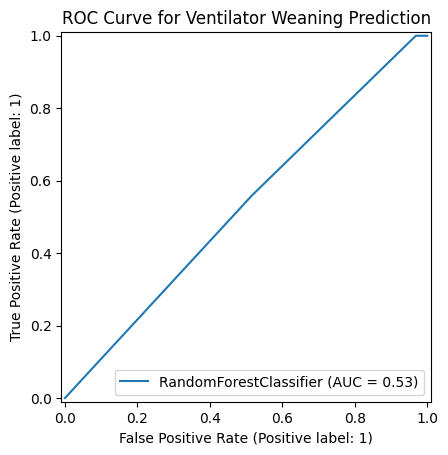

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(rf_model, X_test, y_test)
plt.title("ROC Curve for Ventilator Weaning Prediction")
plt.show()
